In [135]:
import sys
curr_dir = '/user_data/vayzenbe/GitHub_Repos/hemispace'



#add curr_dir to path
sys.path.insert(1, curr_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from glob import glob as glob
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

In [136]:
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
patient_subs = sub_info[sub_info['group'] == 'patient']

data_dir = f'{curr_dir}/behavior/object'
results_dir = f'{curr_dir}/results'
fig_dir = f'{curr_dir}/figures'

conds = [0, 'complete', 'perturbed','deleted']
durations = [.3,.25, .2,.15,.1]
speed = ['intro','slow','slow','fast','fast']


data_files = glob(f'{data_dir}/*.csv')

#load selectivity data
selectivity_summary = pd.read_csv(f'{results_dir}/selectivity/selectivity_summary.csv')
# for each sub in data_summary, get the sub's code from sub_info
for sub in selectivity_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    selectivity_summary.loc[selectivity_summary['sub'] == sub, 'sub_code'] = sub_code

In [137]:


sub_summary = pd.DataFrame(columns = ['sub','cond','duration','acc','rt'])

for sub_file in data_files:


    #check if subfile is not empty
    if len(sub_file) != 0:
        
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #remove practice trials
        sub_data = sub_data[sub_data['pracTrials.ran']!=1]
        acc = sub_data.groupby(['Duration']).mean()
        sem = sub_data.groupby(['Duration']).sem()
        

        #extract rt data where corr is 1
        rt = sub_data[sub_data['resp.corr']==1].groupby(['Duration']).mean()

        temp_summary['acc'] = acc['resp.corr']
        temp_summary['rt'] = rt['resp.rt']
        temp_summary['duration']= acc.index
        temp_summary['sub'] = sub_data['participant'].values.tolist()[0]
        temp_summary['cond'] = sub_data['condition'].values.tolist()[0]
        #temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        #temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > .5:
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

    else:
        print(f'no file for {sub_file}')


#append column for speed
for i in range(len(durations)):
    sub_summary.loc[sub_summary['duration']==durations[i],'speed'] = speed[i]


#reset index
sub_summary = sub_summary.reset_index(drop = True)

#convert sub summary acc to float
sub_summary['acc'] = sub_summary['acc'].astype(float)

#convert duration to string
sub_summary['duration'] = sub_summary['duration'].astype(str)

#replace cond with name
sub_summary['cond'] = sub_summary['cond'].replace(1,'Complete')
sub_summary['cond'] = sub_summary['cond'].replace(2,'Perturbed')
sub_summary['cond'] = sub_summary['cond'].replace(3,'Deleted')




In [138]:
#add group column to sub_summary labeled patient or control
sub_summary['group'] = sub_summary['sub'].apply(lambda x: 'Patient' if x in patient_subs['code'].values else 'Control')

#if patient set intact_hemi to left or right from patient_subs, else set to intact
sub_summary['intact_hemi'] = sub_summary['sub'].apply(lambda x: patient_subs[patient_subs['code']==x]['intact_hemi'].values[0] if x in patient_subs['code'].values else 'Control')


#add sub_code for patients
sub_summary['sub_code'] = sub_summary['sub'].apply(lambda x: str(x) if x in patient_subs['code'].values else '')

sub_summary['intact_hemi'] = sub_summary['intact_hemi'].apply(lambda x: 'Intact left' if x == 'left' else x)
sub_summary['intact_hemi'] = sub_summary['intact_hemi'].apply(lambda x: 'Intact right' if x == 'right' else x)


In [139]:
'''
Create confidence intervals, by resampling control data
'''

iters = 10000 #number of resamples
n =4 #how many subs to sample at a time
cond = 'Complete'
control_summary = sub_summary[(sub_summary['group']=='Control') & (sub_summary['cond']=='Complete')]
control_summary= control_summary.pivot(index='sub', columns='duration', values='acc')

boot_data = pd.DataFrame(columns = ['0.1','0.15','0.2','0.25','0.3'])

for ii in range(0,iters):

    curr_data = control_summary.sample(n=n,replace=True)
    
    data_mean = curr_data.mean().reset_index()

    #append to boot
    boot_data.loc[ii] = data_mean[0].values

    

resamples = pd.melt(boot_data, var_name='duration', value_name='acc')
resamples['intact_hemi'] = 'Control'

In [146]:
#compute CIs for each duration
alpha = .05
control_cis = pd.DataFrame(columns = ['duration','min','max'])
for coln, col in enumerate(boot_data.columns):
    ci = np.percentile(boot_data[col], [(alpha/2)*100, 100-((alpha/2)*100)])
    

    
    control_cis.loc[len(control_cis.index)] = [col, ci[0], ci[1]] 
    
                            
                            
                            
control_cis['intact_hemi'] = "Control"

In [185]:
control_cis

,duration,min,max,intact_hemi
0,0.1,0.959064,1.0,Control
1,0.15,1.000000,1.0,Control
2,0.2,0.850000,1.0,Control
3,0.25,1.000000,1.0,Control
4,0.3,1.000000,1.0,Control


In [186]:
data_mean

,duration,intact_hemi,acc,min,max
0,0.1,Control,0.983918,0.959064,1.000000
1,0.1,Intact left,0.931743,0.898866,0.964621
2,0.1,Intact right,0.913313,0.843065,0.983560
3,0.15,Control,1.000000,1.000000,1.000000
4,0.15,Intact left,0.958333,0.916667,1.000000
5,0.15,Intact right,1.000000,1.000000,1.000000
6,0.2,Control,0.955000,NaN,NaN
7,0.2,Intact left,1.000000,1.000000,1.000000
8,0.2,Intact right,0.950000,0.900000,1.000000
9,0.25,Control,1.000000,NaN,NaN


In [188]:
def create_acc_plot(data_mean, curr_cond):

    p = ggplot(data_mean, aes(x = 'duration', y = 'acc', fill = 'intact_hemi'))  + \
        geom_label(curr_cond, aes(x = 'duration', y = 'acc',fill = 'intact_hemi', label = 'sub_code'),  position = position_jitterdodge(dodge_width=.6, jitter_width = 0.1, random_state = 1),  size = 8) + \
        geom_linerange(aes(x = 'duration', ymin = 'min', ymax = 'max'), position = position_dodge(width=.6), size = 1) + \
        geom_point(position = position_dodge(width=.6), shape = 'o', size = 4,  stroke = 1)  + \
        xlab('Stimulus Duration') + ylab('Accuracy') + ylim(.4, 1) + \
        scale_fill_manual(values = ['#808080','#ee7183', '#7398af']) + \
        theme_classic() + ylim(.4,1) + geom_hline(yintercept = .5, linetype = 'dashed', color = 'black', size = 1) + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(angle = 30, size = 12),
            axis_text_y= element_text(size = 12),
            axis_title=element_text(size = 14),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (10, 6))+ \
            labs(fill='Group') #+ ggtitle(f'{cond}')
        
        
    p.save(f'{fig_dir}/object_behavior.png', width=10, height=6, dpi = 300)
    print(p)

Complete


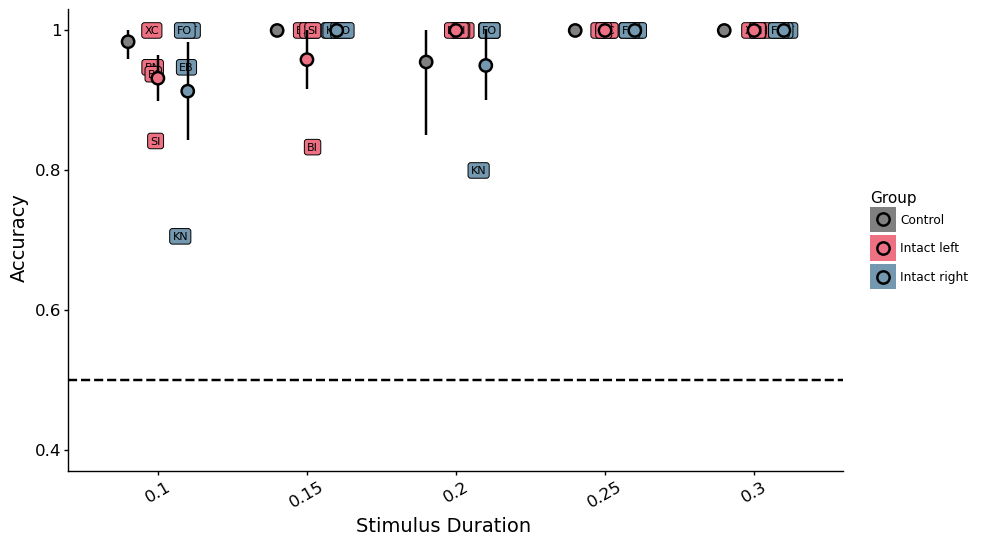

In [190]:
for cond in ['Complete']:

    #extract complete condition
    curr_cond = sub_summary[sub_summary['cond']==cond]

    #calcualte mean and sem for each duration
    data_mean = curr_cond.groupby(['duration', 'intact_hemi']).mean().reset_index()
    sem = curr_cond.groupby(['duration','intact_hemi']).sem().reset_index()
    data_mean['min'] = data_mean['acc'] - sem['acc']
    data_mean['max'] = data_mean['acc'] + sem['acc']
    data_mean.loc[(data_mean['intact_hemi'] == 'Control') , 'min']=control_cis['min'].values
    data_mean.loc[(data_mean['intact_hemi'] == 'Control') , 'max']=control_cis['max'].values
    
    
    

    print(cond)
    #plot
    create_acc_plot(data_mean, curr_cond)

In [7]:
def create_scatter(patient_data):

    p = ggplot(patient_data, aes(x = 'acc', y = 'sum_selec_norm', fill = 'hemi'))  + \
        geom_point(shape = 'o', size = 4,  stroke = 1)  + \
        geom_label(patient_data, aes(x = 'acc', y = 'sum_selec_norm',fill = 'hemi', label = 'sub_code'), size = 8) + \
        xlab('Accuracy') + ylab('Summed Selectivity') + \
        scale_fill_manual(values = ['#ee7183', '#7398af']) + \
        theme_classic() + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(angle = 30, size = 12),
            axis_text_y= element_text(size = 12),
            axis_title=element_text(size = 14),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (6, 6))+ \
            labs(fill='Group') #+ ggtitle(f'{cond}')

    print(p)

no behavioral data for BN
Complete


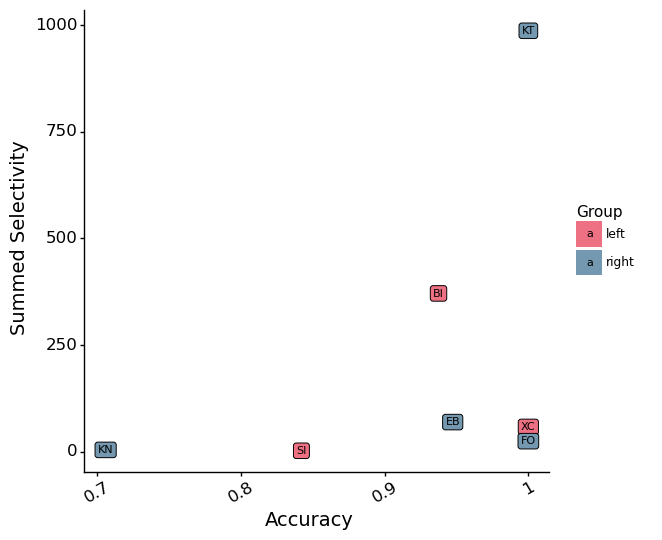


no behavioral data for FO
no behavioral data for BI
no behavioral data for KN
no behavioral data for BN
Perturbed


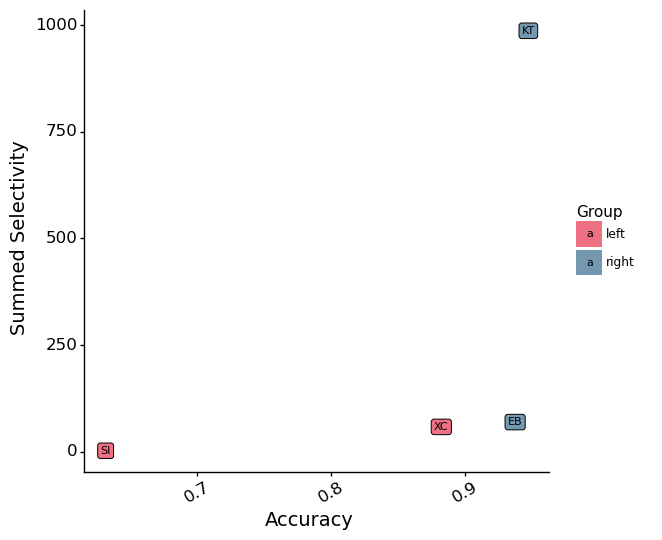


no behavioral data for BI
no behavioral data for BN
Deleted


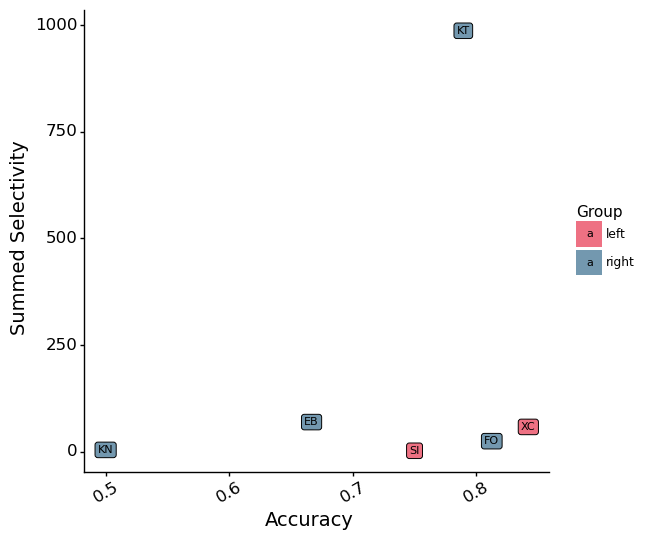

In [8]:
roi = 'dorsal_visual_cortex'
for cond in ['Complete','Perturbed','Deleted']:
    #extract patient data for cond and roi
    patient_data = selectivity_summary[(selectivity_summary['cond']=='space') & (selectivity_summary['roi']==roi) & (selectivity_summary['sub'].isin(patient_subs['sub'].values))]
    behavioral_data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['group'] == 'Patient') ]

    #for each sub append behavioral acc to patient data
    for sub in patient_data['sub_code'].unique():
        try:
            patient_data.loc[patient_data['sub_code']==sub, 'acc'] = behavioral_data[behavioral_data['sub_code']==sub]['acc'].values[0]
            #same for rt
            patient_data.loc[patient_data['sub_code']==sub, 'rt'] = behavioral_data[behavioral_data['sub_code']==sub]['rt'].values[0]

        except:
            print(f'no behavioral data for {sub}')

    print(cond)
    create_scatter(patient_data)

In [15]:
#drop sub columns
sub_summary = sub_summary.drop(columns = ['sub', 'speed'])

mean_summary = sub_summary.groupby(['cond','duration']).mean().reset_index()
mean_summary['se'] = sub_summary.groupby(['cond','duration']).sem().reset_index()['acc']



In [35]:
#convert acc to float
mean_summary['acc'] = mean_summary['acc'].astype(float)
mean_summary['se'] = mean_summary['se'].astype(float)

#convert sub summary acc to float
sub_summary['acc'] = sub_summary['acc'].astype(float)

#convert conds to 'complete', 'perturbed','deleted'
mean_summary['cond'] = mean_summary['cond'].replace(1,'Complete')
mean_summary['cond'] = mean_summary['cond'].replace(2,'Perturbed')
mean_summary['cond'] = mean_summary['cond'].replace(3,'Deleted')



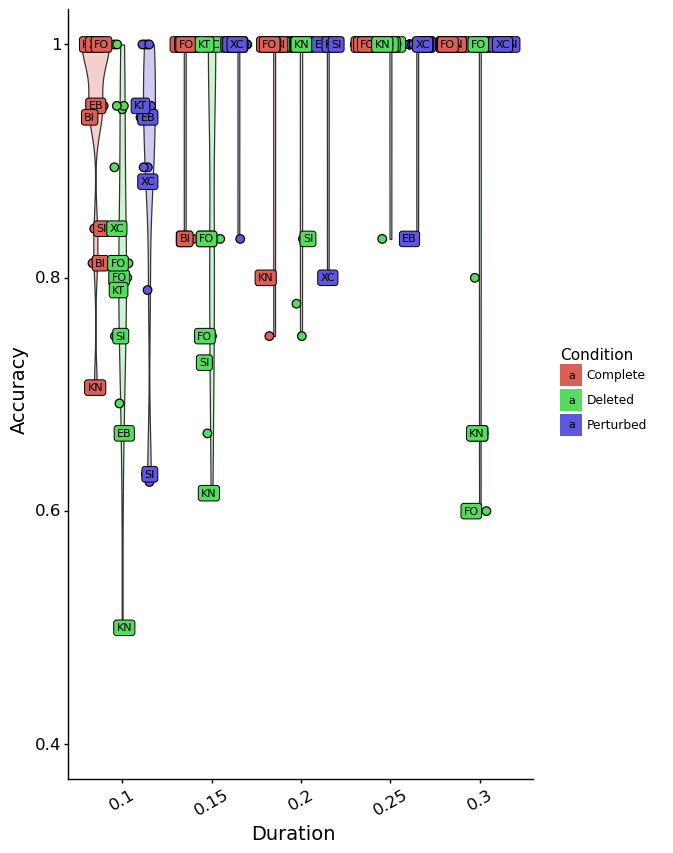

In [12]:

seed = 2
p = ggplot(sub_summary, aes(x = 'duration', y = 'acc', fill = 'cond'))  + \
            geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
            geom_jitter(sub_summary,aes(x = 'duration', y = 'acc', fill = 'cond'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
            geom_label(patient_summary, aes(x = 'duration', y = 'acc',fill = 'cond', label = 'sub'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
            xlab('Duration') + ylab('Accuracy') + \
            theme_classic() + ylim(.4,1) + \
            theme(text = element_text(color ='black'), 
                axis_text_x= element_text(angle = 30, size = 12),
                axis_text_y= element_text(size = 12),
                axis_title=element_text(size = 14),
                axis_line=element_line(), 
                panel_border=element_blank(),
                figure_size = (6, 10))+ \
                labs(fill='Condition') #+ ggtitle(f'{cond}')

#geom_label(indiv_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
#geom_label(indiv_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \

#p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
print(p)

In [17]:

seed = 2
p = ggplot(sub_summary, aes(x = 'duration', y = 'acc', fill = 'cond'))  + \
            geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
            geom_jitter(sub_summary,aes(x = 'duration', y = acc, fill = 'cond'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
            geom_linerange(mean_summary, aes(x = 'duration', ymin = f'acc - se', ymax = f'acc + se', fill = 'cond'), size = 1,position = position_dodge(.9)) + \
            geom_point(mean_summary, aes(x = 'group', y = 'acc', fill = 'cond'), shape = 's', size = 3,position = position_dodge(.9)) + \
            xlab('Duration') + ylab('object recognition') + \
            theme_classic() + \
            theme(text = element_text(color ='black'), 
                axis_text_x= element_text(angle = 30, size = 12),
                axis_text_y= element_text(size = 12),
                axis_title=element_text(size = 14),
                axis_line=element_line(), 
                legend_position = 'none',
                panel_border=element_blank(),
                figure_size = (3, 5))+ \
                labs(fill='Condition') #+ ggtitle(f'{cond}')

#geom_label(indiv_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
#geom_label(indiv_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \

#p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
print(p)

PlotnineError: 'Aesthetics must either be length one, or the same length as the data'

In [16]:
sub_data['participant'].values.tolist()[0]

'5bc6299e8b25de0001d909f8'

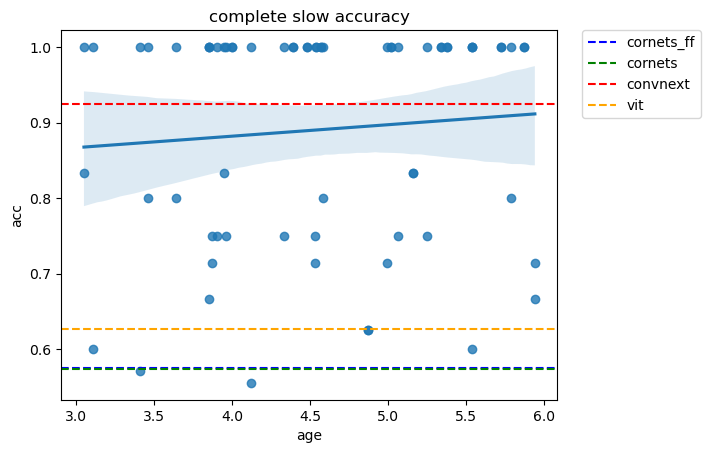

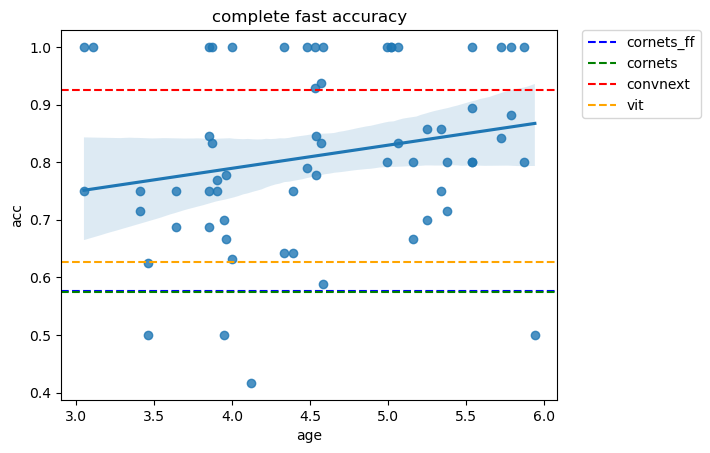

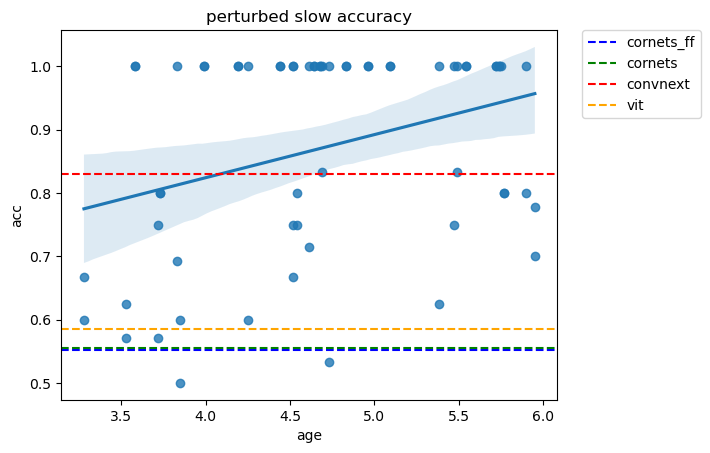

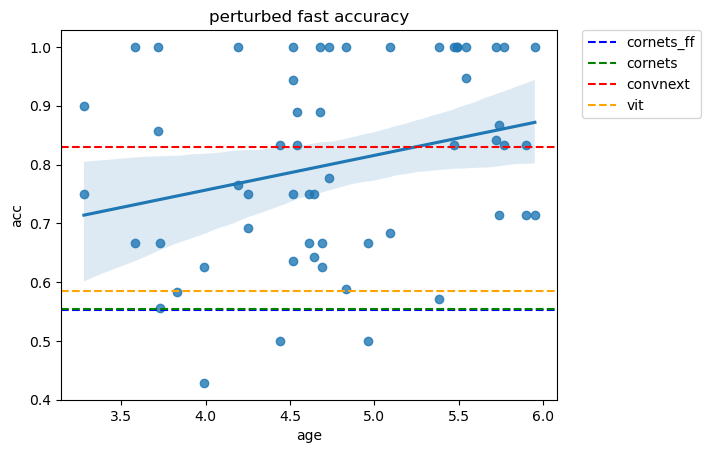

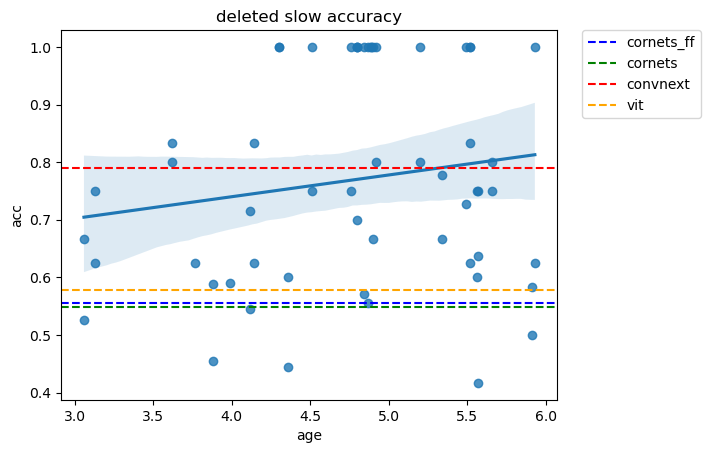

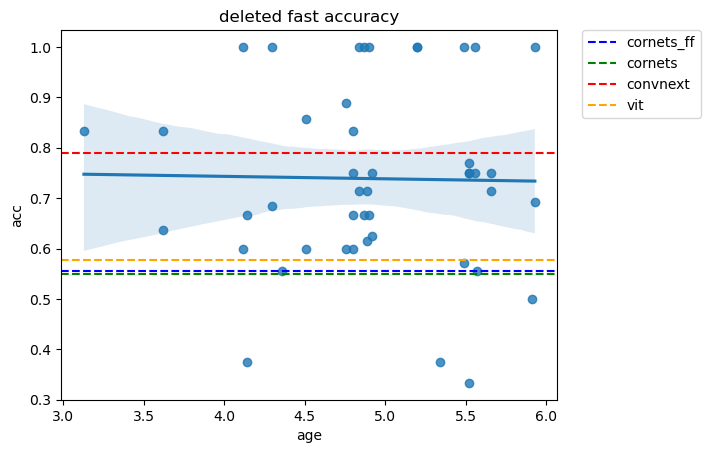

In [63]:
speeds = ['slow','fast']
conds = ['complete','perturbed','deleted']
model_conds = ['Outline','Pert','IC']
sub_summary['age'] = sub_summary['age'].astype(float)
sub_summary['acc'] = sub_summary['acc'].astype(float)

colors = ['b','g','r','orange']



#plot accuracy as a function of speed and condition
for cond in conds:
    for speed in speeds:
        plt.figure()
        #sns.scatterplot(x = 'age', y = 'acc', data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['speed']==speed)])
        ax = sns.regplot(x = 'age', y = 'acc', data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['speed']==speed)])
        plt.title(f'{cond} {speed} accuracy')
        #plt.savefig(f'{results_dir}/{cond}_{speed}_acc.png')
        n = 0
        #load model data in seperate colors as Y-intercept
        for model in models:
            model_data = pd.read_csv(f'{results_dir}/{model}_{model_conds[conds.index(cond)]}_summary.csv')
            model_acc = model_data['acc'].mean()

            #plote model data as a horizontal line
            plt.axhline(y = model_acc, color = colors[n], linestyle = '--',label = model)

            
            n+=1

        handles, _ = ax.get_legend_handles_labels()
        plt.legend(handles = handles[0:],labels = models,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        #place legend outside of graph
        plt.savefig(f'{fig_dir}/{cond}_{speed}_acc.png', bbox_inches='tight')
        plt.show()
        

In [25]:
rt

,resp.corr,resp.rt,pracTrials.thisRepN,pracTrials.thisTrialN,pracTrials.thisN,pracTrials.thisIndex,pracTrials.ran,participant,frameRate,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,trials.ran,objNum
Duration,,,,,,,,,,,,,,,
0.10,1.0,7.779913,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,22.666667,22.666667,11.916667,1.0,19.416667
0.15,1.0,6.317155,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,11.500000,11.500000,14.833333,1.0,24.833333
0.20,1.0,3.647547,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,6.000000,6.000000,18.000000,1.0,28.666667
0.25,1.0,6.800162,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,3.000000,3.000000,12.333333,1.0,19.333333
0.30,1.0,3.573078,NaN,NaN,NaN,NaN,NaN,6001.0,60.0,0.0,0.500000,0.500000,13.500000,1.0,23.000000
